# Mini-Project 1: Machine Learning 101

Christian Martel (260867191)

Luka Loignon (260871296)

Marie Guertin (260870552)

# PART I: Adult Dataset

Prediction task is to determine whether someone makes over 50K a year.
https://archive.ics.uci.edu/ml/datasets/Adult

## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

# other py files
import my_cross_validation
import my_preprocessing

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
np.random.seed(1234)

## Data Preprocessing

### 1. Import Data

In [2]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'salary']
train_df = pd.read_csv("data/adult.data", usecols = range(15), names = columns)
test_df = pd.read_csv("data/adult.test", usecols = range(15), names = columns)
display(train_df)
display(test_df)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,?,321403.0,HS-grad,9.0,Widowed,?,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.


From the imported datasets, we observe that the capital-gain and capital-loss columns contain mostly zeros. These columns are not important features so they will be removed.

Also, we observe that categorical data labels are not stripped.

We can observe that the first row of the test dataset contains junk data, so this row will be removed.

### 2. Strip the Object Data

In [3]:
my_preprocessing.strip_labels(train_df)
my_preprocessing.strip_labels(test_df)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,?,321403.0,HS-grad,9.0,Widowed,?,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.


### 3. Remove Useless Columns and Rows

In [4]:
# remove columns with too much missing data
train_df.drop(columns = ['capital-gain', 'capital-loss'], inplace = True)
test_df.drop(columns = ['capital-gain', 'capital-loss'], inplace = True)

# remove first row containing junk data
test_df.drop(labels=0, inplace = True)

### Check all unique values per feature

In [5]:
# print unique values for each column
for c in train_df.columns:
    print("{c}: ".format(c=c), train_df[c].unique())

age:  [39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
 87]
workclass:  ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
fnlwgt:  [ 77516  83311 215646 ...  34066  84661 257302]
education:  ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
education-num:  [13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]
marital-status:  ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
occupation:  ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'

### 4. Data Imputation

For continuous data: replace Nan values or invalid values with mean value of column

For categorical data: replace Nan values or invalid values with most occurring features

In [6]:
invalid_entries_dict = {
    'age':[],
    'workclass':['?'],
    'fnlwgt':[],
    'education':[],
    'education-num':[],
    'marital-status':[],
    'occupation':['?'],
    'relationship':[],
    'race':[],
    'sex':[],
    'hours-per-week':[],
    'native-country':['?']
}
my_preprocessing.imputation(train_df, invalid_entries_dict)
my_preprocessing.imputation(test_df, invalid_entries_dict)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,salary
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,40.0,United-States,>50K.
5,18,Private,103497.0,Some-college,10.0,Never-married,Prof-specialty,Own-child,White,Female,30.0,United-States,<=50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,36.0,United-States,<=50K.
16278,64,Private,321403.0,HS-grad,9.0,Widowed,Prof-specialty,Other-relative,Black,Male,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,40.0,United-States,<=50K.


### 5. Numerize Prediction Variable

### 6. Categorical Features One-Hot-Encoding 

In [7]:
# pop prediction column
y_train, y_test = train_df.pop('salary'), test_df.pop('salary')

# one-hot-encode categorical features
train_df = my_preprocessing.ohe(train_df)
test_df = my_preprocessing.ohe(test_df)
        
# add back prediction column
train_df, test_df = pd.concat([train_df, y_train],axis=1), pd.concat([test_df, y_test],axis=1)
display(train_df)

,age,fnlwgt,education-num,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,native-country_Cambodia,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,salary
0,39,77516,13,40,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,<=50K
1,50,83311,13,13,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,<=50K
2,38,215646,9,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,<=50K
3,53,234721,7,40,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,<=50K
4,28,338409,13,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,38,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,

## KNN Cross-Validation

In [8]:
from sklearn.neighbors import KNeighborsClassifier

# convert to numpy arrays
train, test = train_df.to_numpy(), test_df.to_numpy()

# split into features set and prediction set
x, y = train[:, :-1], train[:, -1]
x_test, y_test = test[:, :-1], test[:, -1]

# number of folds for L-fold cross-validation
L = 5

# range of number of nearest neighbors (K)
K_list = range(1,21)

# knn cross-validation on full dataset
# acc_val_matrix, acc_train_matrix = my_cross_validation.knn_cross_validation(x, y, K_list, L, my_cross_validation.accuracy)

# Visualize
# plt.title('Accuracy of KNN for Different K Values with Full Dataset')
# plt.plot(K_list, np.mean(acc_train_matrix, axis=1),  label='train')
# plt.errorbar(K_list, np.mean(acc_matrix, axis=1), np.std(acc_matrix, axis=1), label='validation')
# plt.legend()
# plt.xlabel('K (number of neighbours)')
# plt.ylabel('accuracy')
# plt.ylim(0,0.5)
# plt.show()

## Sample Growing Data

Test with different training data sizes

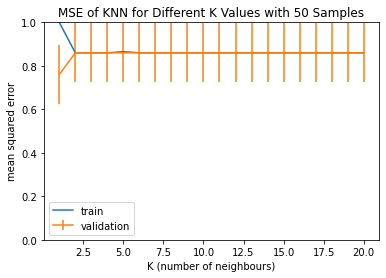

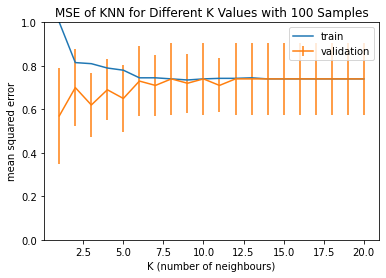

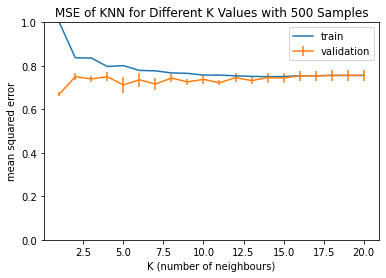

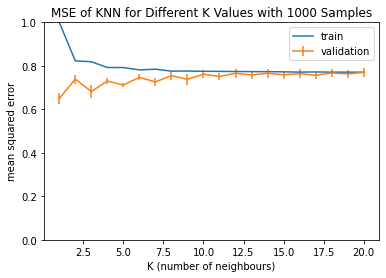

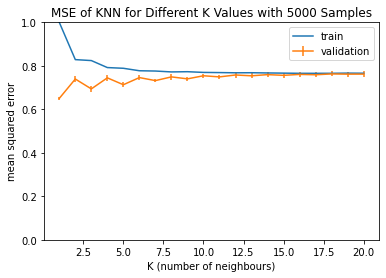

In [ ]:
sizes = [50, 100, 500, 1000, 5000, 10000]

inds = np.random.permutation(range(train.shape[0]))

# K range list
K_list = range(1,21)

for s in sizes:
    # select s random samples from train dataset
    x_subset, y_subset = x[inds[:s]], y[inds[:s]]
    
    # apply cross validation to get validation and train accuracy matrices 
    acc_val_matrix, acc_train_matrix = my_cross_validation.knn_cross_validation(x_subset, y_subset, K_list, L, my_cross_validation.accuracy)
    
    plt.title('Accuracy of KNN for Different K Values with {size} Samples'.format(size = s))
    plt.plot(K_list, np.mean(acc_train_matrix, axis=1),  label='train')
    plt.errorbar(K_list, np.mean(acc_val_matrix, axis=1), np.std(acc_val_matrix, axis=1), label='validation')
    plt.legend()
    plt.xlabel('K (number of neighbours)')
    plt.ylabel('accuracy')
    plt.ylim(0,1)
    plt.show()

## Test with Best Model